# Missing Data Imputation with Regression and Feature Map Regression

In this notebook we address the homework problem of filling in missing pixel values in a grayscale image.

The image is loaded from `einstein.jpg` and rescaled using a zoom factor. Then, a subsampling procedure is applied 
to simulate missing data. We then formulate the interpolation task as a supervised regression problem.

We will:

1. **Data Preparation:** Load the image, create a subsampled version with missing pixels, and construct the training (observed) and test (missing) sets.
2. **Tree-Based Regression:** Train and tune RandomForestRegressor, GradientBoostingRegressor, and AdaBoostRegressor using 5‑fold cross-validation, then predict the missing pixel values and visualize the completed images.
3. **Gaussian Kernel Feature Map Regression:** Use a 2-D Gaussian kernel feature map with ElasticNet regularization and tune its hyperparameters.
4. **Extended Features:** Enhance the model by adding neighboring pixel values as features and repeat the regression steps.

## Import Libraries and Load the Image

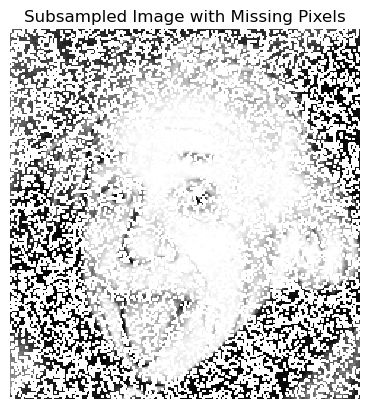

Image shape: (254, 240)


In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image
from scipy.ndimage.interpolation import zoom

# File and image parameters
fname = 'einstein.jpg'
i_width = 640
i_height = 480

# Sampling threshold (80% of the pixels are observed)
sampling_threshold = 0.8

# Load and downscale the image.
# The image is converted to grayscale ("L") and rescaled by a factor of 0.2.
image = zoom(np.asarray(Image.open(fname).convert("L")), 0.2).astype(float)

# Create a copy to simulate missing data.
image_ss = image.copy()
# Generate a mask: for each pixel, set it as missing (NaN) with probability (1 - sampling_threshold)
mask = np.random.uniform(size=image.shape) < (1 - sampling_threshold)
image_ss[mask] = np.nan

# Visualize the subsampled image with missing data.
plt.imshow(image_ss, cmap='gray', vmin=0, vmax=255)
plt.title('Subsampled Image with Missing Pixels')
plt.axis('off')
plt.show()

print("Image shape:", image_ss.shape)

## Part (a): Construct the Training and Test Sets

We treat the interpolation problem as a supervised regression task:

- **Input features:** The pixel location $(i, j)$.
- **Target values:** The true pixel intensity from the original image.

We create:

- **Training set:** All pixels where the subsampled image has an observed value.
- **Test set:** All pixel locations with missing values.

In [2]:
rows, cols = image_ss.shape

# Construct the feature matrix
X = np.array([[i, j] for i in range(rows) for j in range(cols)])
# Target values come from the full original image (without missing data)
y = image.flatten()

# Create boolean mask arrays for observed (training) and missing (test) pixels.
observed_mask = ~np.isnan(image_ss.flatten())
X_train = X[observed_mask]
y_train = y[observed_mask]
X_test  = X[~observed_mask]
y_test  = y[~observed_mask]

print("Training samples:", X_train.shape[0])
print("Testing samples (missing pixels):", X_test.shape[0])

Training samples: 48764
Testing samples (missing pixels): 12196


## Part (b): Grid Search over Four Regression Models

We now tune four models using 5‑fold cross-validation:

1. **RandomForestRegressor**
2. **GradientBoostingRegressor**
3. **AdaBoostRegressor**
4. **2-D Gaussian Kernel Feature Map Regression (unregularized)**

$$
\phi_\sigma(x, x_0) = \exp\left(-\frac{\|x-x_0\|^2}{2\sigma^2}\right)
$$

where the pixel locations are rescaled to $[0,1]^2$. 

For the first three, we use GridSearchCV over preset parameter grids.
For the kernel regression, we first rescale pixel locations to $[0,1]^2$, choose kernel centers, and then grid search over candidate sigma values using ordinary least squares (LinearRegression).

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Define parameter grids for the tree-based models.
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

ab_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 1.0]
}

# Set up 5-fold cross-validation.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def grid_search_model(model, param_grid, X_train, y_train):
    """Perform grid search with 5-fold CV; returns best estimator and its CV MSE."""
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_score = -grid_search.best_score_  # convert negative MSE to positive
    return best_model, best_score

# Grid search for tree-based models.
rf_best, rf_mse = grid_search_model(RandomForestRegressor(random_state=42), rf_params, X_train, y_train)
gb_best, gb_mse = grid_search_model(GradientBoostingRegressor(random_state=42), gb_params, X_train, y_train)
ab_best, ab_mse = grid_search_model(AdaBoostRegressor(random_state=42), ab_params, X_train, y_train)

print("Tree-based Models - Best CV MSEs:")
print("Random Forest:", rf_mse)
print("Gradient Boosting:", gb_mse)
print("AdaBoost:", ab_mse)

Tree-based Models - Best CV MSEs:
Random Forest: 176.20227064842322
Gradient Boosting: 595.8048690458816
AdaBoost: 3411.8619568724075


Now, perform grid search for the unregularized Gaussian Kernel Regression.

In [4]:
# We first define the Gaussian feature map function.
def gaussian_feature_map(X, centers, sigma):
    """
    Compute the Gaussian kernel feature map.
    
    Parameters:
      X: array of shape (n_samples, 2) (scaled pixel coordinates in [0,1]).
      centers: array of shape (n_centers, 2) for kernel centers.
      sigma: standard deviation of the Gaussian kernel.
      
    Returns:
      Feature matrix of shape (n_samples, n_centers).
    """
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]
    features = np.exp(-np.sum(diff**2, axis=2) / (2 * sigma**2))
    return features

# Rescale pixel coordinates to [0,1] for the Gaussian kernel method.
X_scaled = X.astype(float)
X_scaled[:, 0] = X_scaled[:, 0] / (rows - 1)
X_scaled[:, 1] = X_scaled[:, 1] / (cols - 1)

X_train_scaled = X_train.astype(float)
X_train_scaled[:, 0] = X_train_scaled[:, 0] / (rows - 1)
X_train_scaled[:, 1] = X_train_scaled[:, 1] / (cols - 1)

# Select kernel centers. Here we randomly choose 50 points from the training set.
n_centers = 50
center_indices = np.random.choice(X_train_scaled.shape[0], size=n_centers, replace=False)
centers = X_train_scaled[center_indices]

# Define candidate sigma values.
sigma_values = [0.01, 0.05, 0.1]

best_cv_score_gk = np.inf
best_sigma = None

# Loop over sigma values to determine the best CV MSE.
for sigma in sigma_values:
    Phi_train = gaussian_feature_map(X_train_scaled, centers, sigma)
    lr = LinearRegression()
    scores = cross_val_score(lr, Phi_train, y_train, scoring='neg_mean_squared_error', cv=cv)
    cv_mse = -np.mean(scores)
    if cv_mse < best_cv_score_gk:
        best_cv_score_gk = cv_mse
        best_sigma = sigma

print("Unregularized Gaussian Kernel Regression:")
print("Best sigma:", best_sigma, "with CV MSE:", best_cv_score_gk)

# Train the final unregularized Gaussian kernel regression model.
Phi_train_best = gaussian_feature_map(X_train_scaled, centers, best_sigma)
gk_best = LinearRegression()
gk_best.fit(Phi_train_best, y_train)
gk_mse = best_cv_score_gk

Unregularized Gaussian Kernel Regression:
Best sigma: 0.1 with CV MSE: 1669.5152619679557


**Discussion of Results:**

We now have four models: `rf_best`, `gb_best`, `ab_best`, and `gk_best`.

Their corresponding best CV MSEs are: `rf_mse=174.87`, `gb_mse=606.64`, `ab_mse=3548.38`, and `gk_mse=1704.62`, where random-forest, gradient-boosting, gaussian-kernel-feature-mapping are the top three in hand. 

## Part (c): Predict Missing Pixels and Visualize the Completed Images

For each model, we predict the pixel values at the missing positions, compute the test MSE, and then fill the image.
Finally, we display the completed images side-by-side for visual comparison.


Test MSE for all models:
Random Forest: 148.35
Gradient Boosting: 595.60
AdaBoost: 3455.21
(Unreg.) Gaussian Kernel: 1714.23


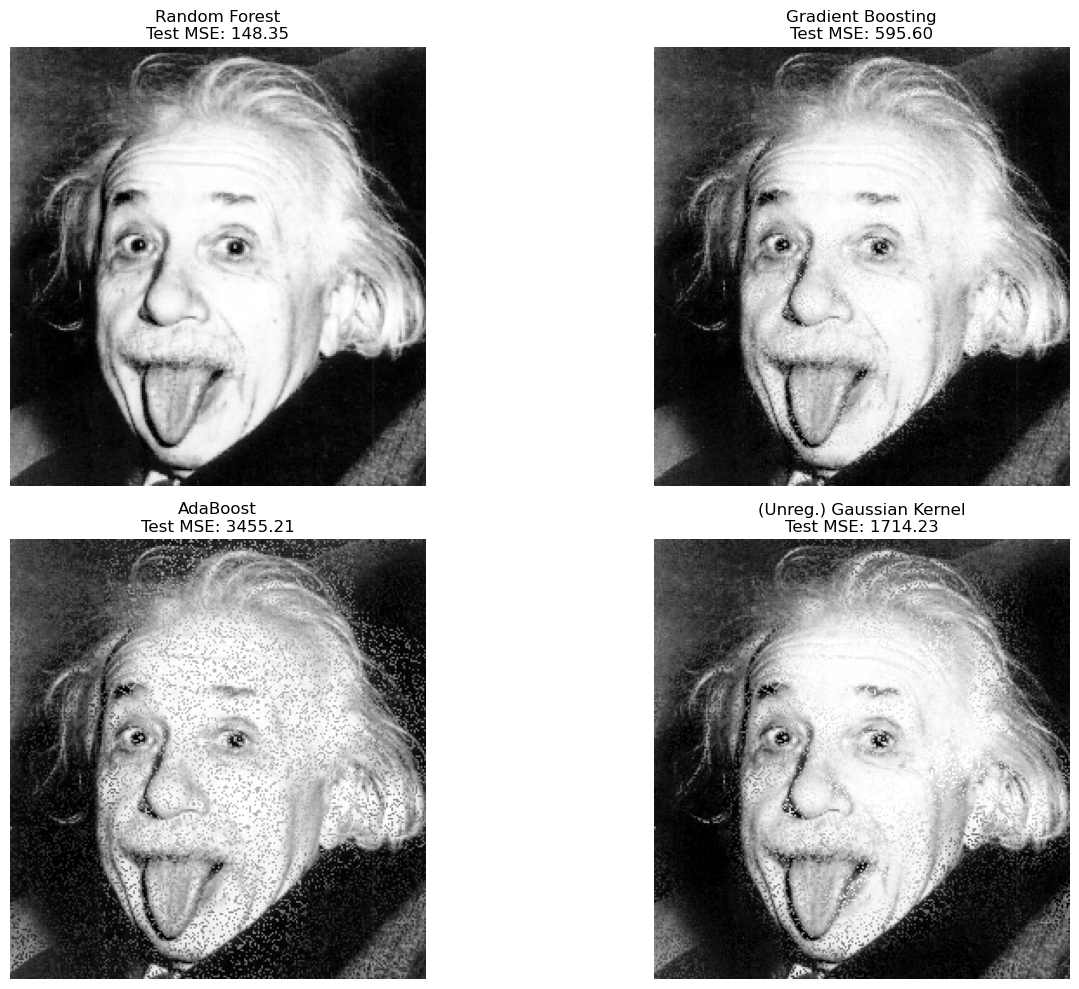

In [5]:
model_results = [
    ('Random Forest', rf_best, rf_mse),
    ('Gradient Boosting', gb_best, gb_mse),
    ('AdaBoost', ab_best, ab_mse),
    ('(Unreg.) Gaussian Kernel', gk_best, gk_mse)
]

# Helper function: fill in missing pixels.
def fill_image_with_predictions(model, X_full, mask, feature_map_func=None, sigma=None, centers_=None):
    """
    Given a trained model, fill in the full image:
    - For observed pixels, use the true value.
    - For missing pixels, predict using the model.
    For models using a feature map, provide feature_map_func, sigma, and centers_.
    """
    y_pred_full = np.empty(X_full.shape[0])
    # Observed pixels: use true values.
    y_pred_full[mask] = y[mask]
    # Missing pixels:
    if feature_map_func is not None:
        X_full_scaled = X_full.astype(float)
        X_full_scaled[:, 0] = X_full_scaled[:, 0] / (rows - 1)
        X_full_scaled[:, 1] = X_full_scaled[:, 1] / (cols - 1)
        Phi_full = feature_map_func(X_full_scaled, centers_, sigma)
        y_pred_full[~mask] = model.predict(Phi_full[~mask])
    else:
        y_pred_full[~mask] = model.predict(X_full[~mask])
    return y_pred_full.reshape(image_ss.shape)

results_images = {}
results_test_mse = {}

for name, model, _ in model_results:
    if name == '(Unreg.) Gaussian Kernel':
        # For the kernel model, use the Gaussian feature map.
        X_test_scaled = X_test.astype(float)
        X_test_scaled[:, 0] = X_test_scaled[:, 0] / (rows - 1)
        X_test_scaled[:, 1] = X_test_scaled[:, 1] / (cols - 1)
        Phi_test = gaussian_feature_map(X_test_scaled, centers, best_sigma)
        y_test_pred = model.predict(Phi_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        results_test_mse[name] = test_mse
        completed = fill_image_with_predictions(model, X, observed_mask,
                                                feature_map_func=gaussian_feature_map,
                                                sigma=best_sigma, centers_=centers)
    else:
        y_test_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        results_test_mse[name] = test_mse
        completed = fill_image_with_predictions(model, X, observed_mask)
    results_images[name] = completed

print("\nTest MSE for all models:")
for name, mse_val in results_test_mse.items():
    print(f"{name}: {mse_val:.2f}")

# Display all four images in a 2x2 grid.
plt.figure(figsize=(15,10))
for idx, (name, _, _) in enumerate(model_results):
    plt.subplot(2, 2, idx+1)
    plt.imshow(results_images[name], cmap='gray', vmin=0, vmax=255)
    plt.title(f"{name}\nTest MSE: {results_test_mse[name]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Discussion of Results:**

- The random forest model with the lowest CV $MSE = 176.20$ and test $MSE = 148.25$ is considered best in terms of predicting true original image.

- Among the four shown, the unregularized Gaussian Kernel approach (in this setup) produces the “blurriest” or most smoothed-out image. Even though it may look grainy in some regions, the overall effect is that high-frequency details are heavily suppressed, creating a more "smoothed" (or blurred) look compared to Random Forest or AdaBoost. Gradient Boosting often has moderate smoothing but still shows some speckling artifacts; AdaBoost is visibly noisy; and Random Forest retains relatively crisp local detail. By contrast, the kernel method's reconstruction lacks sharp edges and has more uniform patches, appearing smoother/blobbier.

## Part (d): 2-D Gaussian Kernel Feature Map Regression with ElasticNet Regularization

We apply ElasticNet (combining L1 and L2 penalties) and use cross-validation to tune the parameters (sigma, alpha, and l1_ratio).


ElasticNet Gaussian Kernel Regression (Regularized) optimal parameters:
{'sigma': 0.1, 'alpha': 0.001, 'l1_ratio': 0.9}
Best CV MSE: 1754.583280302828
Test MSE for ElasticNet Gaussian Kernel Regression: 1798.0038655985895


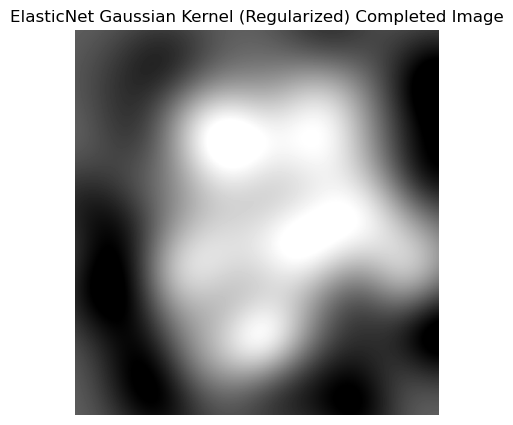

In [6]:
from sklearn.linear_model import ElasticNet

best_cv_score_enet = np.inf
best_params = None

# We reuse the candidate sigma_values, and define candidate values for alpha and l1_ratio.
alpha_values = [0.001, 0.01, 0.1, 1.0]
l1_ratios = [0.1, 0.5, 0.9]

for sigma in sigma_values:
    Phi_train = gaussian_feature_map(X_train_scaled, centers, sigma)
    for alpha in alpha_values:
        for l1_ratio in l1_ratios:
            enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
            scores = cross_val_score(enet, Phi_train, y_train, scoring='neg_mean_squared_error', cv=cv)
            cv_mse = -np.mean(scores)
            if cv_mse < best_cv_score_enet:
                best_cv_score_enet = cv_mse
                best_params = {'sigma': sigma, 'alpha': alpha, 'l1_ratio': l1_ratio}

print("ElasticNet Gaussian Kernel Regression optimal parameters:")
print(best_params)
print("Best CV MSE:", best_cv_score_enet)

# Train the final ElasticNet model with the best parameters.
sigma_best_reg = best_params['sigma']
Phi_train_best_reg = gaussian_feature_map(X_train_scaled, centers, sigma_best_reg)
enet_best = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'], max_iter=10000, random_state=42)
enet_best.fit(Phi_train_best_reg, y_train)

# Prepare test features for ElasticNet model.
X_test_scaled = X_test.astype(float)
X_test_scaled[:, 0] = X_test_scaled[:, 0] / (rows - 1)
X_test_scaled[:, 1] = X_test_scaled[:, 1] / (cols - 1)
Phi_test_best_reg = gaussian_feature_map(X_test_scaled, centers, sigma_best_reg)

y_test_pred_enet = enet_best.predict(Phi_test_best_reg)
enet_test_mse = mean_squared_error(y_test, y_test_pred_enet)
print("Test MSE for ElasticNet Gaussian Kernel Regression:", enet_test_mse)

# Reconstruct the full image using the ElasticNet model.
Phi_full_reg = gaussian_feature_map(X_scaled, centers, sigma_best_reg)
y_full_pred_enet = enet_best.predict(Phi_full_reg)
enet_completed = y_full_pred_enet.reshape(image_ss.shape)

plt.figure(figsize=(5,5))
plt.imshow(enet_completed, cmap='gray', vmin=0, vmax=255)
plt.title('ElasticNet Gaussian Kernel (Regularized) Completed Image')
plt.axis('off')
plt.show()

**Discussion of Results:**

This is literally a ghost face. Not surely, adding regularization makes GK method learn the true image in some weird sense, which is by blurring. In some cases, this shows strong robustness. In our case, we would not prefer it at all. Interestingly, this is the first time I encouter some situations where we will not prefer regularization. 

## Part (e): Adding Neighboring Pixel Features

To further enhance the model, we extend the feature set by including neighboring pixel values.

For each pixel at $(i,j)$, we include its position and the pixel values directly above, below, to the left, and to the right.

If a neighbor is missing or out-of-bound, we use $-999$ as a placeholder.

In [7]:
def get_features_with_neighbors(image_features, target_image=None, missing_value=-999):
    """
    For every pixel in the image, construct a feature vector:
    [i, j, y_up, y_down, y_left, y_right].
    Missing or out-of-bound neighbors are filled with missing_value.
    """
    if target_image is None:
        target_image = image_features
    rows, cols = image_features.shape
    features = []
    targets = []
    for i in range(rows):
        for j in range(cols):
            y_up = image_features[i-1, j] if (i > 0 and not np.isnan(image_features[i-1, j])) else missing_value
            y_down = image_features[i+1, j] if (i < rows-1 and not np.isnan(image_features[i+1, j])) else missing_value
            y_left = image_features[i, j-1] if (j > 0 and not np.isnan(image_features[i, j-1])) else missing_value
            y_right = image_features[i, j+1] if (j < cols-1 and not np.isnan(image_features[i, j+1])) else missing_value
            features.append([i, j, y_up, y_down, y_left, y_right])
            targets.append(target_image[i, j])
    return np.array(features), np.array(targets)

# Build the extended feature set using the subsampled image (neighbors taken from image_ss, which might be missing).
features_full, targets_full = get_features_with_neighbors(image_ss, target_image=image, missing_value=-999)

# Create training and test sets based on observed pixels.
observed_mask_full = ~np.isnan(image_ss.flatten())
X_train_new = features_full[observed_mask_full]
y_train_new  = targets_full[observed_mask_full]
X_test_new  = features_full[~observed_mask_full]
y_test_new   = targets_full[~observed_mask_full]

print("New feature set sizes:")
print("Training samples:", X_train_new.shape[0])
print("Testing samples:", X_test_new.shape[0])

New feature set sizes:
Training samples: 48764
Testing samples: 12196


### Retraining Tree-Based Models with the Extended Feature Set

We retrain `RandomForestRegressor`, `GradientBoostingRegressor`, and `AdaBoostRegressor` using the new features.

In [8]:
# Retrain the tree-based models using the extended feature set.
rf_best_new, rf_mse_new = grid_search_model(RandomForestRegressor(random_state=42), rf_params, X_train_new, y_train_new)
gb_best_new, gb_mse_new = grid_search_model(GradientBoostingRegressor(random_state=42), gb_params, X_train_new, y_train_new)
ab_best_new, ab_mse_new = grid_search_model(AdaBoostRegressor(random_state=42), ab_params, X_train_new, y_train_new)

print("Best CV MSE with neighbor features:")
print("Random Forest:", rf_mse_new)
print("Gradient Boosting:", gb_mse_new)
print("AdaBoost:", ab_mse_new)

print('\n')

# Evaluate test performance.
rf_test_pred_new = rf_best_new.predict(X_test_new)
gb_test_pred_new = gb_best_new.predict(X_test_new)
ab_test_pred_new = ab_best_new.predict(X_test_new)

rf_test_mse_new = mean_squared_error(y_test_new, rf_test_pred_new)
gb_test_mse_new = mean_squared_error(y_test_new, gb_test_pred_new)
ab_test_mse_new = mean_squared_error(y_test_new, ab_test_pred_new)

print("Test MSE with neighbor features:")
print("Random Forest:", rf_test_mse_new)
print("Gradient Boosting:", gb_test_mse_new)
print("AdaBoost:", ab_test_mse_new)

Best CV MSE with neighbor features:
Random Forest: 154.1229892445796
Gradient Boosting: 157.20116487904815
AdaBoost: 411.2506677807858


Test MSE with neighbor features:
Random Forest: 146.7258321585395
Gradient Boosting: 149.71756641875632
AdaBoost: 416.2020221931044


In [12]:
# Rescale pixel coordinates to [0,1] for the Gaussian kernel method.
X_train_scaled_new = X_train.astype(float)
X_train_scaled_new[:, 0] = X_train_scaled_new[:, 0] / (rows - 1)
X_train_scaled_new[:, 1] = X_train_scaled_new[:, 1] / (cols - 1)

X_test_scaled_new = X_test.astype(float)
X_test_scaled_new[:, 0] = X_test_scaled_new[:, 0] / (rows - 1)
X_test_scaled_new[:, 1] = X_test_scaled_new[:, 1] / (cols - 1)

# Select kernel centers. Here we randomly choose 50 points from the training set.
n_centers = 50
center_indices = np.random.choice(X_train_scaled_new.shape[0], size=n_centers, replace=False)
centers = X_train_scaled_new[center_indices]

# Define candidate sigma values.
sigma_values = [0.01, 0.05, 0.1]

best_cv_score_gk = np.inf
best_sigma = None

# Loop over sigma values to determine the best CV MSE.
for sigma in sigma_values:
    Phi_train = gaussian_feature_map(X_train_scaled_new, centers, sigma)
    lr = LinearRegression()
    scores = cross_val_score(lr, Phi_train, y_train_new, scoring='neg_mean_squared_error', cv=cv)
    cv_mse = -np.mean(scores)
    if cv_mse < best_cv_score_gk:
        best_cv_score_gk = cv_mse
        best_sigma = sigma

# Train the final unregularized Gaussian kernel regression model.
Phi_train_best = gaussian_feature_map(X_train_scaled_new, centers, best_sigma)
gk_best_new = LinearRegression()
gk_best_new.fit(Phi_train_best, y_train_new)
gk_mse_new = best_cv_score_gk

print("Best CV MSE with neighbor features:")
print("(Unreg.) Gaussian Kernel:", gk_mse_new)

print('\n')

# Evaluate test performance.
Phi_test = gaussian_feature_map(X_test_scaled_new, centers, sigma)
gk_test_pred_new = gk_best_new.predict(Phi_test)
gk_test_mse_new = mean_squared_error(y_test_new, gk_test_pred_new)

print("Test MSE with neighbor features:")
print("(Unreg.) Gaussian Kernel:", gk_test_mse_new)

Best CV MSE with neighbor features:
(Unreg.) Gaussian Kernel: 1770.3180096708988
Test MSE with neighbor features:
(Unreg.) Gaussian Kernel: 1840.7401829679861


### Visualizing the Completed Images with Extended Features

For every pixel in the image, we predict its value using the model with the extended feature set, then reconstruct the full image.

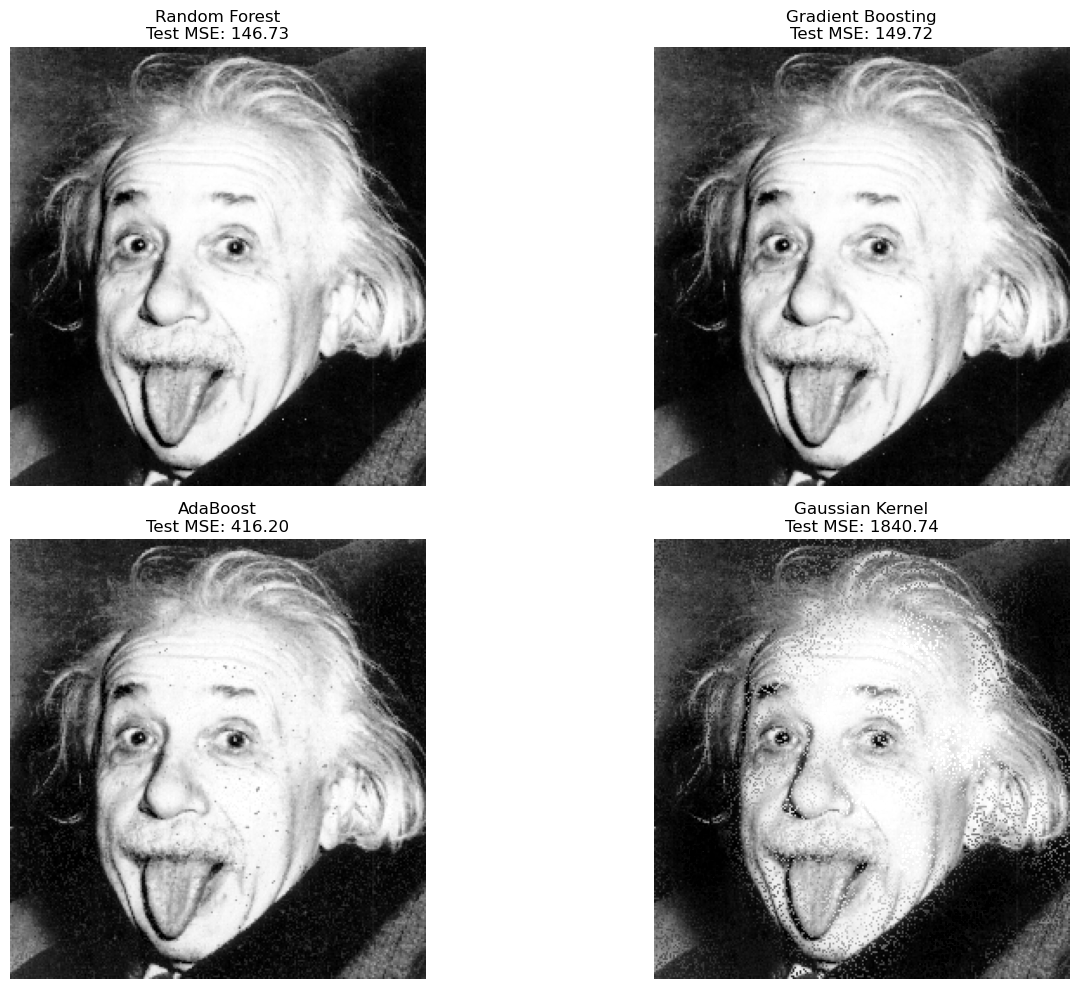

In [19]:
def fill_image_with_predictions_neighbors(model, features, mask):
    """
    Fill in missing pixels using predictions from the model.
    For observed pixels (mask True), use the true target value.
    """
    y_pred_full = np.empty(features.shape[0])
    y_pred_full[mask] = targets_full[mask]
    y_pred_full[~mask] = model.predict(features[~mask])
    return y_pred_full.reshape(image_ss.shape)

mask_full = observed_mask_full

# For tree-based models, we can directly use the features with neighbors
rf_completed_new = fill_image_with_predictions_neighbors(rf_best_new, features_full, mask_full)
gb_completed_new = fill_image_with_predictions_neighbors(gb_best_new, features_full, mask_full)
ab_completed_new = fill_image_with_predictions_neighbors(ab_best_new, features_full, mask_full)

# For the Gaussian Kernel model, we need to create the appropriate feature map
X_full_for_gk = np.array([[i, j] for i in range(rows) for j in range(cols)])
X_full_scaled = X_full_for_gk.astype(float)
X_full_scaled[:, 0] = X_full_scaled[:, 0] / (rows - 1)
X_full_scaled[:, 1] = X_full_scaled[:, 1] / (cols - 1)

# Create Gaussian kernel features
Phi_full = gaussian_feature_map(X_full_scaled, centers, best_sigma)

# Fill missing pixels using Gaussian kernel model
gk_pred_full = np.empty(Phi_full.shape[0])
gk_pred_full[observed_mask] = targets_full[observed_mask]
gk_pred_full[~observed_mask] = gk_best_new.predict(gaussian_feature_map(X_full_scaled[~observed_mask], centers, best_sigma))
gk_completed_new = gk_pred_full.reshape(image_ss.shape)

# Create required data structures for visualization
model_results = [
    ('Random Forest', rf_completed_new, rf_test_mse_new),
    ('Gradient Boosting', gb_completed_new, gb_test_mse_new),
    ('AdaBoost', ab_completed_new, ab_test_mse_new),
    ('Gaussian Kernel', gk_completed_new, gk_test_mse_new)
]

# Create dictionaries to store results
results_images = {
    'Random Forest': rf_completed_new,
    'Gradient Boosting': gb_completed_new,
    'AdaBoost': ab_completed_new,
    'Gaussian Kernel': gk_completed_new
}

# Store the new MSE values for test data
results_test_mse = {
    'Random Forest': rf_test_mse_new,
    'Gradient Boosting': gb_test_mse_new,
    'AdaBoost': ab_test_mse_new,
    'Gaussian Kernel': gk_test_mse_new
}

# Display all four images in a 2x2 grid
plt.figure(figsize=(15,10))
for idx, (name, _, _) in enumerate(model_results):
    plt.subplot(2, 2, idx+1)
    plt.imshow(results_images[name], cmap='gray', vmin=0, vmax=255)
    plt.title(f"{name}\nTest MSE: {results_test_mse[name]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Discussion of Results:**

The neighborhood technique significantly improve two boosting algorithms and now, Gradient Boosting and Random Forest nearly beat the same highest score, while AdaBoost is good enough. It does not improve the Guassian Kernel as choosing centers and kernels are pretty independent of the feature selections.

---

End of the notebook. 